# Constants

In [2]:
DRUM_CLASSES = [
   'Kick',
   'Snare',
   'Hi-hat closed',
   'Hi-hat open',
   'Tom low',
   'Tom mid', 
   'Tom high',
   'Clap',
   'Rim' 
]

MIDI_DRUM_MAP = {
    36: 0,
    38: 1,
    40: 1,
    37: 1,
    48: 5,
    50: 6,
    45: 4,
    47: 5,
    43: 4,
    58: 4,
    46: 3,
    26: 3,
    42: 2,
    22: 2,
    44: 2,
    49: 7,
    55: 7,
    57: 7,
    52: 7,
    51: 8,
    59: 8,
    53: 8 
}
    
resolution  = 4 # separate quater into 4  = 16 notes per bar

nb_bars = 2 

len_seq = resolution * 4 * nb_bars # length of drumloops in training data - 2 bars
    
nb_notes = len(DRUM_CLASSES) # number of possible MIDI notes  - max_drum_note - min_drum_note


# Preprocessing Data

This script assumes that you have downloaded [Google Groove MIDI dataset](https://magenta.tensorflow.org/datasets/groove), uncompssed and move the uncompressed `groove` folder into `./midi_dataset/` directory.  


In [1]:
from glob import glob
import os

os.environ["CUDA_VISIBLE_DEVICES"] = '0' #only relevant in my own environement

# We are only handling 4/4 beats
filepaths = glob("./midi_dataset/groove/*/*/*beat_4-4.mid")
print(len(filepaths))

491


In [21]:
# genres 
all_genres = {}
for path in filepaths:
    _path = os.path.basename(path)
    path = _path.split("_")[1]
    genre = path.split("-")[0]
    if genre not in all_genres:
        all_genres[genre] = 1
    else:
        all_genres[genre] += 1        
print (all_genres)

# genre used. ignore smaller genres
GENRES = []
for genre, nb in all_genres.items():
    if nb > 25:
        GENRES.append(genre)
print("Genres", GENRES)
NB_GENRES = len(GENRES)

{'funk': 53, 'latin': 48, 'highlife': 2, 'rock': 204, 'afrobeat': 13, 'dance': 7, 'neworleans': 13, 'hiphop': 34, 'soul': 28, 'pop': 15, 'jazz': 48, 'afrocuban': 7, 'punk': 7, 'gospel': 1, 'country': 2, 'reggae': 4, 'middleeastern': 1, 'blues': 4}
Genres ['funk', 'latin', 'rock', 'hiphop', 'soul', 'jazz']


In [3]:
# Utility function
import matplotlib.pyplot as plt
%matplotlib inline

def plot_drum_matrix(a):
    if a is not None:
        a = np.transpose(np.squeeze(a))
        plt.matshow(a)
        plt.show()        

## MIDI -> Piano roll matrix

84 ./midi_dataset/groove/drummer7/session2/2_rock_120_beat_4-4.mid


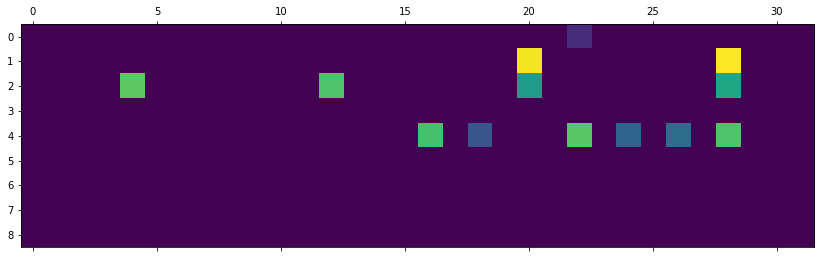

In [37]:
import random
import numpy as np
import os
import joblib
import pretty_midi
import glob

import matplotlib.pyplot as plt
%matplotlib inline

MIN_NB_ONSETS = 8

def plot_drum_matrix(a):
    if a is not None:
        a = np.transpose(np.squeeze(a))
        plt.matshow(a)
        plt.show()  

# unit timestep = 16th note
def get_pianomatrices_of_drums(midi_file, is_drum=True):
    found = False
    genre_id = -1
    
    # is it in selected genres?
    for id_, genre in enumerate(GENRES):
        if genre in midi_file:
            found = True
            genre_id = id_
            break
    if found is False:
        return (None, None, None, None)
    
    # load midi file
    try:
        pm = pretty_midi.PrettyMIDI(midi_file)
    except:
        print ("Failed to load midi: ", midi_file)
        return (None, None, None, None)
        
    # get timiming of quater notes
    beats = pm.get_beats()
    
    # make it to 16th notes
    beats_ticks = [] # converting to ticks
    
    for i in range((len(beats) +1)* 4):
        beats_ticks.append(i * pm.resolution / 4)
    
    num_notes16 = len(beats_ticks)
    print(num_notes16, midi_file)
    
    # maximum duration of one note
    max_duration = 2.0 # 2 quater notes

    # convert ticks to index of 16th note
    def find_note_index(tick, beats_ticks):
        return (np.abs(beats_ticks - tick)).argmin()
    
    def get_timeshift(beats_ticks, grid_id, note_start):
        grid_start = beats_ticks[grid_id]
        tick_diff = note_start - grid_start
        tick_grid = pm.resolution / 4        
        diff_coef= tick_diff / tick_grid * 2.0
        return diff_coef
        
    # # of notes
    notes_length = 4 * nb_bars * resolution

    # create pianoroll matrix (resolution: 16th note))
    found_extra = False # with other than kick/snare/hat
    pianorolls, timeshifts, durations, genre_ids = [], [], [], []
    for instrument in pm.instruments:
        if instrument.is_drum == is_drum:  # use drum tracks only
            
            for note_start in range(0, num_notes16 - 16, 16): # hopsize = 1bar = 16 16th notes
                pianoroll = np.zeros((notes_length, nb_notes), dtype='float') 
                timeshift = np.zeros((notes_length, nb_notes), dtype='float')
                duration = np.zeros((notes_length, nb_notes), dtype='float')

                for note in instrument.notes:
                    idx_start = find_note_index(pm.time_to_tick(note.start), beats_ticks)
                    diff_coef = get_timeshift(beats_ticks, idx_start, pm.time_to_tick(note.start))

                    if note_start <= idx_start and idx_start < note_start + notes_length:
                        if note.pitch in MIDI_DRUM_MAP:
                            drum_note = MIDI_DRUM_MAP[note.pitch]
                            
                            pianoroll[idx_start - note_start, drum_note] = note.velocity / 128.
                            timeshift[idx_start - note_start, drum_note] = diff_coef

                            dur = (pm.time_to_tick(note.end) - pm.time_to_tick(note.start))/ (pm.resolution / 4)
                            dur = min(1.0, max(0, dur / max_duration))
                            duration[idx_start - note_start, drum_note] = dur

                            if drum_note >= 3:
                                found_extra = True
                        else:
                            print("not found", note.pitch )
                
                if np.sum(pianoroll > 0.) >= MIN_NB_ONSETS:
                    pianorolls.append(pianoroll)
                    timeshifts.append(timeshift)
                    durations.append(duration)
                    genre_ids.append(genre_id)
             
    # ignore the first and the last one!
    pianorolls = np.array(pianorolls)
    timeshifts = np.array(timeshifts)
    durations = np.array(durations)
    genre_ids = np.array(genre_ids)
    
    return (pianorolls,timeshifts, durations, genre_ids)
    
# Testing MIDI files
midi_file = random.choice(filepaths)
(drums, timeshift, duration, genre_ids) = get_pianomatrices_of_drums(midi_file)    

if drums is not None:
    plot_drum_matrix(drums[0])

In [42]:
# Batch processing - be patient. 
matrices_drum_list = joblib.Parallel(n_jobs=-1, verbose=5)(
   joblib.delayed(get_pianomatrices_of_drums)(midi_file, True)     
     for midi_file in filepaths)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 452 tasks      | elapsed: 18.5min
[Parallel(n_jobs=-1)]: Done 484 out of 491 | elapsed: 18.6min remaining:   16.1s
[Parallel(n_jobs=-1)]: Done 491 out of 491 | elapsed: 40.5min finished


### Store the pianoroll matrix to a file for the later use

In [50]:
# remove invlid values -  TODO: clean up the code
matrices_drums_selected = [a for a in matrices_drum_list if a is not None]
matrices_drums_selected = [a for a in matrices_drums_selected if (a[0] is not None and a[0].shape[0] == a[1].shape[0] and a[1].shape[0] == a[2].shape[0] and a[2].shape[0] == a[3].shape[0] and a[0].shape[0]>0)]

matrices_drums_ = [a[0] for a in matrices_drums_selected] # if a is not None and len(a[0].shape)==3 and a[3].shape[0] == a[0].shape[0]]
matrices_times_ = [a[1] for a in matrices_drums_selected] # if a is not None and len(a[1].shape)==3 and a[3].shape[0] == a[0].shape[0]]
matrices_durations_ = [a[2] for a in matrices_drums_selected] #if a is not None and len(a[2].shape)==3 and a[3].shape[0] == a[0].shape[0]]
matrices_genre_ids_ = [np.squeeze(a[3]) for a in matrices_drums_selected] #if a is not None and a[3].ndim==1 and a[3].shape[0] == a[0].shape[0]]

matrices_drums = np.vstack(matrices_drums_)
print (matrices_drums.shape)

matrices_times = np.vstack(matrices_times_)
print (matrices_times.shape)

matrices_durations = np.vstack(matrices_durations_)
print (matrices_durations.shape)

matrices_genre_ids = np.hstack(matrices_genre_ids_)
print (matrices_genre_ids.shape)

# save
os.makedirs("./tmp", exist_ok=True)
np.savez("./tmp/matrices_drum_groove.npz", drum_data=matrices_drums, timeshift=matrices_times,
         durations=matrices_durations, genre_ids=matrices_genre_ids, genres=GENRES)


(16620, 32, 9)
(16620, 32, 9)
(16620, 32, 9)
(16620,)


### Load preprocessed MIDI matrix

In [ ]:
# import numpy as np

# matrices_drums = np.load("./tmp/matrices_drum_groove.npz")["drum_data"]
# matrices_times = np.load("./tmp/matrices_drum_groove.npz")["timeshift"]
# matrices_durations = np.load("./tmp/matrices_drum_groove.npz")["durations"]

# print (matrices_drums.shape)
# print (matrices_times.shape)

# VAE Model Definition

In [51]:
from keras.layers import Layer

# KL Divergence Loss Layer
class KLDivergenceLayer(Layer):

    def __init__(self, *args, **kwargs):
        self.is_placeholder = True
        super(KLDivergenceLayer, self).__init__(*args, **kwargs)
        
    def call(self, inputs):

        mu, log_var = inputs

        kl_batch = - .5 * K.sum(1 + log_var -
                                K.square(mu) -
                                K.exp(log_var), axis=-1)

        self.add_loss(K.mean(kl_batch), inputs=inputs)

        return inputs    

In [53]:
import numpy as np
from keras.layers import Input, Dense, Flatten, Dropout, Reshape, LSTM, Bidirectional, Lambda, Concatenate
from keras.layers.convolutional import Conv2D

from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import RMSprop, Adam
import keras.backend as K
from keras.models import Model, Sequential

# constants
batch_size = 16
n_z = 4
dropout_rate = 0.30

# Encoder
# input for onsets
drum_input = Input(shape=(len_seq, nb_notes), name='drum_input')  # tensorflow order
x = Bidirectional(LSTM(64, return_sequences=True, activation='tanh'))(drum_input) 
x = Bidirectional(LSTM(128, return_sequences=True, activation='tanh'))(x)
x = Bidirectional(LSTM(16, return_sequences=True, activation='tanh'))(x)
x1 = Reshape((1024,))(x)

# input for timeshifts
timeshift_input = Input(shape=(len_seq, nb_notes), name='timeshift_input')  # tensorflow order
x = Bidirectional(LSTM(64, return_sequences=True, activation='tanh'))(timeshift_input) 
x = Bidirectional(LSTM(128, return_sequences=True, activation='tanh'))(x)
x = Bidirectional(LSTM(16, return_sequences=True, activation='tanh'))(x)
x2 = Reshape((1024,))(x)

# input for duration
duration_input = Input(shape=(len_seq, nb_notes), name='duration_input')  # tensorflow order
x = Bidirectional(LSTM(64, return_sequences=True, activation='tanh'))(duration_input) 
x = Bidirectional(LSTM(128, return_sequences=True, activation='tanh'))(x)
x = Bidirectional(LSTM(16, return_sequences=True, activation='tanh'))(x)
x3 = Reshape((1024,))(x)

x_merged =  Concatenate()([x1, x2, x3])
x = Dense(1024, activation='relu')(x_merged)
x = Dense(512, activation='relu')(x)
x = Dense(128, activation='relu')(x)

# VAE 
mu = Dense(n_z, activation='linear')(x)
log_sigma = Dense(n_z, activation='linear')(x)

# KL Divergence
mu, log_sigma = KLDivergenceLayer()([mu, log_sigma])

# Sampling for Z
def sample_z(args):
    
    mu, log_sigma = args
    
    batch = K.shape(mu)[0]
    dim = K.int_shape(mu)[1]
    
    eps = K.random_normal(shape=(batch, dim), mean=0., stddev=1.)

    return mu + K.exp(log_sigma / 2.) * eps

z = Lambda(sample_z, output_shape=(n_z,), name='z')([mu, log_sigma])

encoder = Model([drum_input, timeshift_input, duration_input], [mu, log_sigma, z], name='encoder')
encoder.summary()

# Decoder
latent_inputs = Input(shape=(n_z,), name='z_sampling')

# output for onsets
x = Dense(64, activation='relu')(latent_inputs)
x = Dropout(dropout_rate)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(dropout_rate)(x)
x1 = Dense(512, activation='relu')(x)

x = Dropout(dropout_rate)(x1)
x = Dense(1024, activation='relu')(x)
x = Dropout(dropout_rate)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(dropout_rate)(x)
x = Dense(288, activation='sigmoid')(x) # output range shoud be 0. - 1.
note_out = Reshape((len_seq, nb_notes), name='note_output')(x)

# output for timeshift
x = Dense(1024, activation='relu')(x1)
x = Dropout(dropout_rate)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(dropout_rate)(x)
x = Dense(288, activation='tanh')(x) # output range shoud be -1. - 1.
time_out = Reshape((len_seq, nb_notes), name='time_output')(x)

# output for duration
x = Dense(1024, activation='relu')(x1)
x = Dropout(dropout_rate)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(dropout_rate)(x)
x = Dense(288, activation='sigmoid')(x) # output range shoud be -1. - 1.
duration_out = Reshape((len_seq, nb_notes), name='duration_output')(x)

decoder = Model(latent_inputs, [note_out, time_out, duration_out], name='decoder')
decoder.summary()

# VAE model
inputs = [drum_input,timeshift_input, duration_input]
outputs = decoder(encoder(inputs)[2])

vae = Model(inputs, outputs, name='VAE')
vae.summary()


W0723 17:39:13.143459 4554200512 deprecation_wrapper.py:119] From /Users/nao/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0723 17:39:13.184642 4554200512 deprecation_wrapper.py:119] From /Users/nao/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0723 17:39:13.190716 4554200512 deprecation_wrapper.py:119] From /Users/nao/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0723 17:39:16.596175 4554200512 deprecation_wrapper.py:119] From /Users/nao/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0723 17:39:16.742543 4554200512 

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
drum_input (InputLayer)         (None, 32, 9)        0                                            
__________________________________________________________________________________________________
timeshift_input (InputLayer)    (None, 32, 9)        0                                            
__________________________________________________________________________________________________
duration_input (InputLayer)     (None, 32, 9)        0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) (None, 32, 128)      37888       drum_input[0][0]                 
__________________________________________________________________________________________________
bidirectio

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
drum_input (InputLayer)         (None, 32, 9)        0                                            
__________________________________________________________________________________________________
timeshift_input (InputLayer)    (None, 32, 9)        0                                            
__________________________________________________________________________________________________
duration_input (InputLayer)     (None, 32, 9)        0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 4), (None, 4 4746248     drum_input[0][0]                 
                                                                 timeshift_input[0][0]            
          

[[ 1.08205225 -0.85115243 -0.70084623 -1.95948441]]
(1, 32, 9) (1, 32, 9)


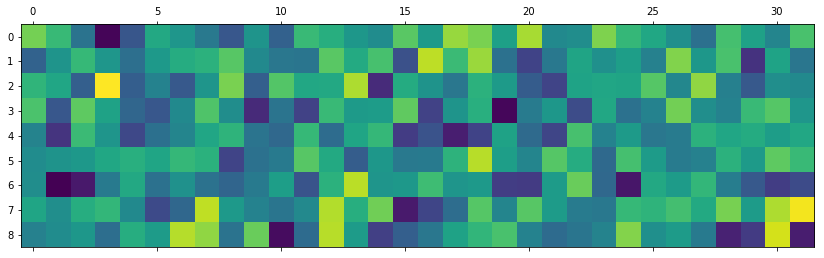

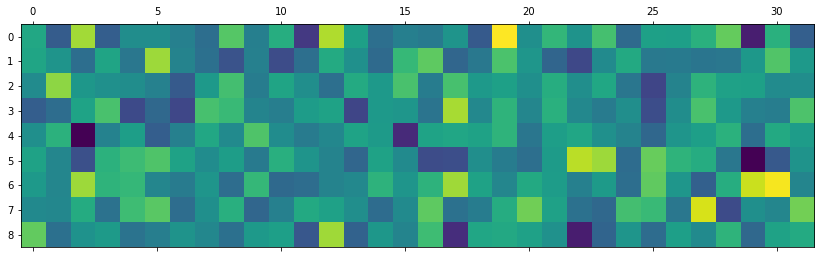

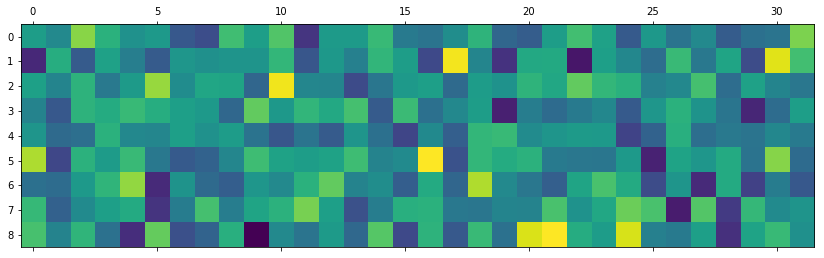

In [54]:
# Test 
for i in range(1):
    random_z = np.random.normal(0.0, 1.0, (1, n_z))
    print (random_z)
    a,t,d = decoder.predict(random_z)
    print (a.shape, t.shape)
    plot_drum_matrix(a) # onsets
    plot_drum_matrix(t) # timeshifts
    plot_drum_matrix(d) # durations


# Training

In [55]:

from keras.losses import mse, binary_crossentropy

def nll_loss(y_true, y_pred):
    """ Calculate loss = reconstruction loss + KL loss for eatch data in minibatch """
    # reconstruction loss
    bc = K.binary_crossentropy(y_true, y_pred) 
    recon = K.sum( K.sum(bc, axis=-1), axis=-1)
    return recon

In [56]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='val_loss', min_delta=0, patience=15, verbose=1, mode='auto')
cp = ModelCheckpoint("./tmp/vae_{epoch:02d}-{val_loss:.2f}.hdf5", monitor='val_loss', verbose=1, save_best_only=True, period=3)
vae.compile(optimizer='adam', loss=nll_loss, loss_weights=[1.0, 0.5, 0.5], metrics=['mse'])

vae.fit([matrices_drums, matrices_times, matrices_durations], [matrices_drums, matrices_times, matrices_durations], 
        shuffle=True, batch_size=64, epochs=100, verbose=1, validation_split=0.05, callbacks=[es, cp])

W0723 17:39:33.152168 4554200512 deprecation_wrapper.py:119] From /Users/nao/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0723 17:39:33.176584 4554200512 deprecation.py:323] From /Users/nao/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 15789 samples, validate on 831 samples
Epoch 1/100
15789/15789 [==============================] - 125s 8ms/step - loss: 66.4449 - decoder_loss: 50.7727 - decoder_mean_squared_error: 0.0396 - decoder_mean_squared_error_1: 0.4249 - decoder_mean_squared_error_2: 0.0176 - val_loss: 82.8074 - val_decoder_loss: 37.6347 - val_decoder_mean_squared_error: 0.0403 - val_decoder_mean_squared_error_1: 0.3720 - val_decoder_mean_squared_error_2: 0.0108
Epoch 2/100
15789/15789 [==============================] - 114s 7ms/step - loss: 57.1767 - decoder_loss: 45.2008 - decoder_mean_squared_error: 0.0342 - decoder_mean_squared_error_1: 0.4342 - decoder_mean_squared_error_2: 0.0129 - val_loss: 75.8683 - val_decoder_loss: 34.1954 - val_decoder_mean_squared_error: 0.0349 - val_decoder_mean_squared_error_1: 0.3815 - val_decoder_mean_squared_error_2: 0.0093
Epoch 3/100
15789/15789 [==============================] - 127s 8ms/step - loss: 53.1799 - decoder_loss: 42.8844 - decoder_mean_squared_error: 0.0

15789/15789 [==============================] - 104s 7ms/step - loss: 46.3880 - decoder_loss: 39.0956 - decoder_mean_squared_error: 0.0260 - decoder_mean_squared_error_1: 0.5320 - decoder_mean_squared_error_2: 0.0099 - val_loss: 69.6159 - val_decoder_loss: 31.5601 - val_decoder_mean_squared_error: 0.0303 - val_decoder_mean_squared_error_1: 0.4580 - val_decoder_mean_squared_error_2: 0.0083
Epoch 21/100
15789/15789 [==============================] - 96s 6ms/step - loss: 46.2155 - decoder_loss: 38.9838 - decoder_mean_squared_error: 0.0258 - decoder_mean_squared_error_1: 0.5343 - decoder_mean_squared_error_2: 0.0098 - val_loss: 69.1530 - val_decoder_loss: 31.3307 - val_decoder_mean_squared_error: 0.0298 - val_decoder_mean_squared_error_1: 0.4729 - val_decoder_mean_squared_error_2: 0.0082

Epoch 00021: val_loss improved from 69.71070 to 69.15304, saving model to ./tmp/vae_21-69.15.hdf5
Epoch 22/100
15789/15789 [==============================] - 102s 6ms/step - loss: 46.0672 - decoder_loss: 3

15789/15789 [==============================] - 118s 7ms/step - loss: 44.2796 - decoder_loss: 37.8915 - decoder_mean_squared_error: 0.0240 - decoder_mean_squared_error_1: 0.6827 - decoder_mean_squared_error_2: 0.0092 - val_loss: 69.0162 - val_decoder_loss: 31.0741 - val_decoder_mean_squared_error: 0.0294 - val_decoder_mean_squared_error_1: 0.6586 - val_decoder_mean_squared_error_2: 0.0080

Epoch 00039: val_loss did not improve from 68.49232
Epoch 40/100
15789/15789 [==============================] - 133s 8ms/step - loss: 44.1907 - decoder_loss: 37.8563 - decoder_mean_squared_error: 0.0238 - decoder_mean_squared_error_1: 0.6815 - decoder_mean_squared_error_2: 0.0092 - val_loss: 68.8982 - val_decoder_loss: 31.0499 - val_decoder_mean_squared_error: 0.0293 - val_decoder_mean_squared_error_1: 0.6467 - val_decoder_mean_squared_error_2: 0.0081
Epoch 41/100
15789/15789 [==============================] - 134s 9ms/step - loss: 44.1554 - decoder_loss: 37.8214 - decoder_mean_squared_error: 0.0238 -

In [135]:
# save trained models
vae.save("vae_model_groove.h5")
encoder.save("encoder_model_groove.h5")
decoder.save("decoder_model_groove.h5")

# Test

### Reconstruction

Input -----------
onsets


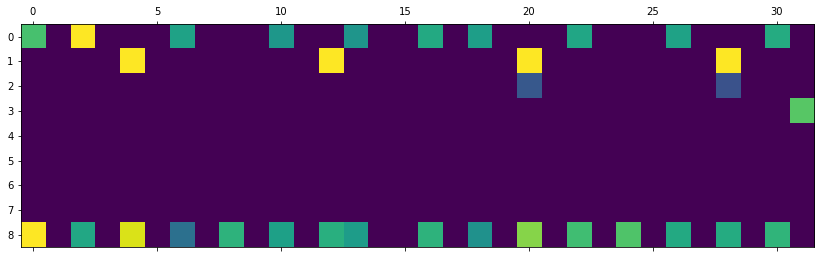

time shift


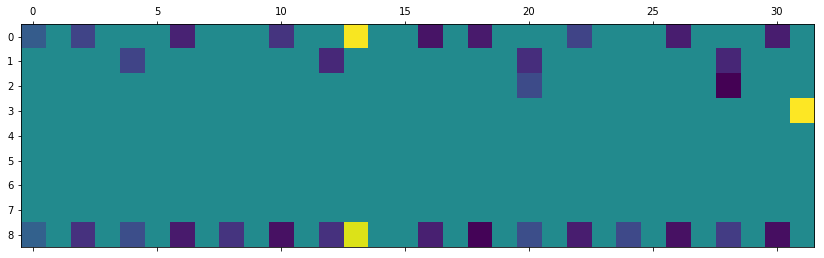

durations


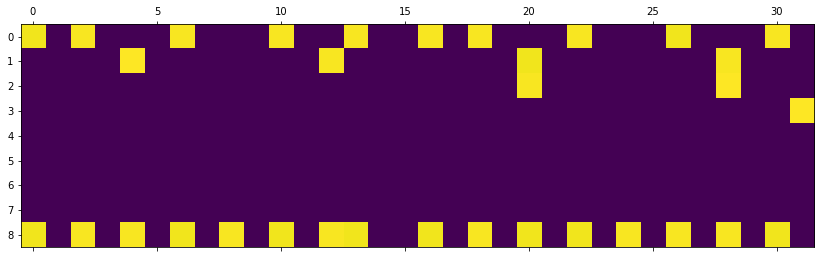

Reconstructed ---------
onsets


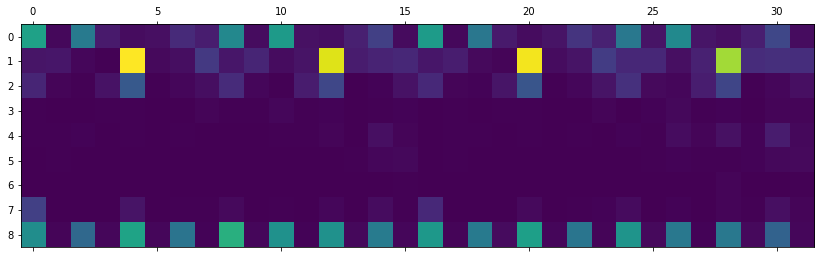

time shift


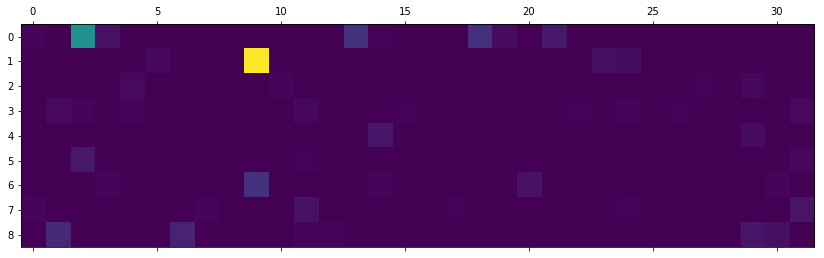

durations


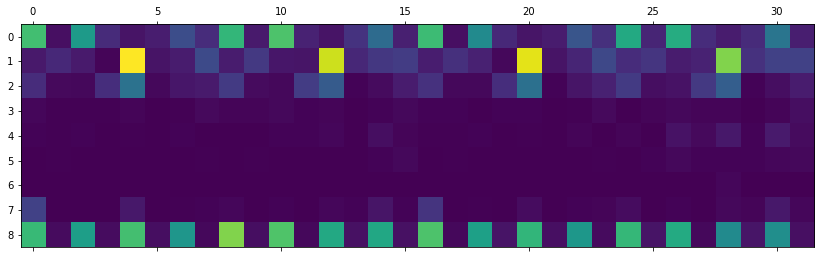

In [64]:
import random
    
print ("Input -----------")
print ("onsets")
index = random.randint(0, matrices_drums.shape[0])
b = matrices_drums[index]
plot_drum_matrix(b)
print ("time shift")
t = matrices_times[index]
plot_drum_matrix(t)
print ("durations")
d = matrices_durations[index]
plot_drum_matrix(d)

print("Reconstructed ---------")
n, t, d = vae.predict([np.array([b]), np.array([t]),np.array([d])])
print ("onsets")
plot_drum_matrix(n)
print ("time shift")
plot_drum_matrix(t)
print ("durations")
plot_drum_matrix(d)


### Random Generation

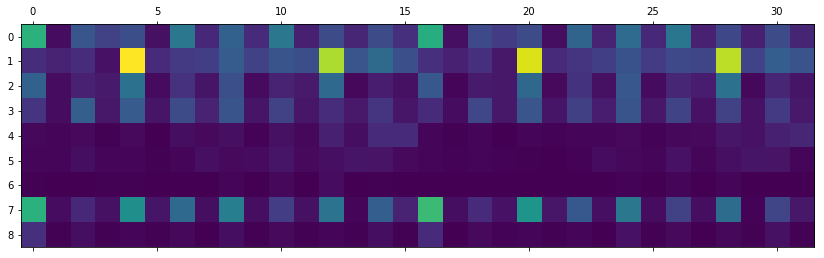

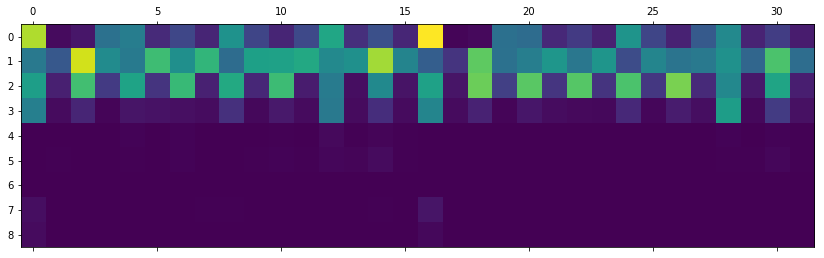

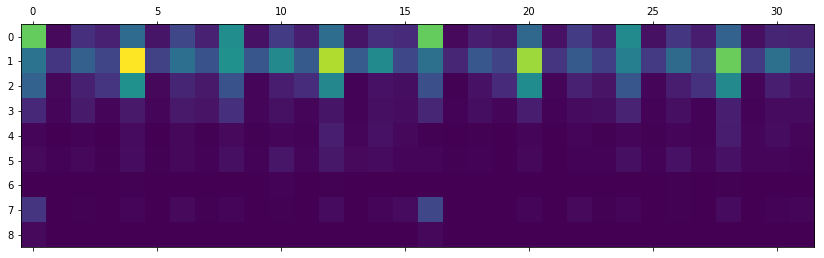

In [65]:
for i in range(3):
    random_z = np.random.normal(0.0, 1.0, (1, n_z))
    a,_,_ = decoder.predict(random_z)
    plot_drum_matrix(a)